In [1]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [4]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/EndoQuad_hg19.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 4.36 s, total: 2min 1s
Wall time: 2min


# Data selection

In [ ]:
width = 100

ei_1 = [[],[]]

for i in range(width-1):
    if i+1 < width:
        ei_1[0].append(i)
        ei_1[0].append(i+1)
        ei_1[1].append(i+1)
        ei_1[1].append(i)

edge = torch.tensor(np.array(ei_1), dtype=torch.long)

In [ ]:
import numpy as np
from itertools import product

def generate_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    for i in range(1, n + 1):
        subgroups.extend([''.join(p) for p in product(nucleotides, repeat=i)])
    return subgroups

def encode_sequence_as_features_ndarray(n_str: str, k_str: str):
    n = len(n_str)
    k = len(k_str)
    result = np.zeros(n, dtype=int)
    
    for i in range(n - k + 1):
        if n_str[i:i+k] == k_str:
            result[i:i+k] = 1
    
    return result.tolist()

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels, intervals, k_mer=1, groups=['A','T','G','C'],
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.dna_source = dna_source
        self.labels = labels
        self.intervals = intervals
        
        self.k_mer = k_mer
        self.groups = groups
        
        self.ei = [[],[]]
        for i in range(width-1):
            self.ei[0].append(i)
            self.ei[0].append(i+1)
            self.ei[1].append(i+1)
            self.ei[1].append(i)

        super().__init__(transform, pre_transform, pre_filter)

    def len(self):
        return len(self.intervals)

    def get(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        
        dna_OHE = []
        
        for group in self.groups:
            featuress = encode_sequence_as_features_ndarray(self.dna_source[chrom][begin:end].upper(), group)
            
            dna_OHE.append(featuress)
        
        dna_OHE = list(map(list, zip(*dna_OHE)))
        dna_OHE = np.array(dna_OHE)
        feature_matr = []

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)


        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)

        return Data(x=X.unsqueeze(0), y=y.unsqueeze(0))

In [7]:
np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 57772.78it/s]


In [99]:
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [100]:
groups = generate_subgroups(4)

In [101]:
np.random.seed(42)
train_dataset = GraphDataset(chrom_names, feature_names,
                            DNA, DNA_features,
                            ZDNA, train_intervals, 4, groups)

test_dataset = GraphDataset(chrom_names, feature_names,
                           DNA, DNA_features,
                           ZDNA, test_intervals, 4, groups)

In [106]:
np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# Train and test

In [ ]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

np.random.seed(42)
def loss_func(output, y_batch):
    np.random.seed(42)

    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer, loader_train):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()

    for dt in loader_train:
        x, y = dt.x.cuda(),  dt.y.cuda().long()
        
        optimizer.zero_grad()

        output = model(x)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred)
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
                          
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output.permute([0, 2, 1]), y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def test(model, loader_test):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()

    means = []
    for dt in loader_test:
        x, y = dt.x.cuda(), dt.y.cuda().long()
        

        output = model(x)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=-1)
        
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred) 
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten()) 
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output.permute([0, 2, 1]), y)
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    np.random.seed(42)
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs, loader_train, loader_test, max_length):
    np.random.seed(42)
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []

    for epoch in range(n_epochs):
        print(f"Max {max_length}-mer. Epoch {epoch + 1} of {n_epochs}")
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt, loader_train)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model, loader_test)
        
        end_time = time.time()
        
        t = end_time - start_time
        times.append(t)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))


        clear_output()
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss))
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Time: ", t/60)
        print(f"Max {max_length}-mer. Epoch {epoch+1}: ROC-AUC = {val_auc_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}:  Precision = {val_pr_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}: Recall = {val_rec_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}: F1-score = {val_f1_log[-1]:.3}")


    print(f"Max {max_length}-mer. Final ROC-AUC = {val_auc_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final Precision = {val_pr_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final Recall = {val_rec_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final F1-score = {val_f1_log[-1]:.3}")

    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times

In [108]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Модели

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphZSAGEConv_13L(torch.nn.Module):
    def __init__(self, top_count):
        super(GraphZSAGEConv_13L, self).__init__()
        
        self.conv1 = SAGEConv(top_count, 1024)
        self.conv2 = SAGEConv(1024, 1024)
        self.conv3 = SAGEConv(1024, 512)
        self.conv4 = SAGEConv(512, 512)
        self.conv5 = SAGEConv(512, 256)
        
        self.conv6 = SAGEConv(256, 256)
        self.conv7 = SAGEConv(256, 128)
        self.conv8 = SAGEConv(128, 128)
        self.conv9 = SAGEConv(128, 64)
        self.conv10 = SAGEConv(64, 64)
        
        self.conv11 = SAGEConv(64, 32)
        self.conv12 = SAGEConv(32, 32)
        self.conv13 = SAGEConv(32, 2)
        
        self.norm1 = torch.nn.GroupNorm(num_groups=512, num_channels=1024)
        self.norm2 = torch.nn.GroupNorm(num_groups=512, num_channels=1024)
        self.norm3 = torch.nn.GroupNorm(num_groups=256, num_channels=512)
        self.norm4 = torch.nn.GroupNorm(num_groups=256, num_channels=512)
        self.norm5 = torch.nn.GroupNorm(num_groups=128, num_channels=256)
        self.norm6 = torch.nn.GroupNorm(num_groups=128, num_channels=256)
        self.norm7 = torch.nn.GroupNorm(num_groups=64, num_channels=128)
        self.norm8 = torch.nn.GroupNorm(num_groups=64, num_channels=128)
        self.norm9 = torch.nn.GroupNorm(num_groups=32, num_channels=64)
        self.norm10 = torch.nn.GroupNorm(num_groups=32, num_channels=64)
        self.norm11 = torch.nn.GroupNorm(num_groups=16, num_channels=32)
        self.norm12 = torch.nn.GroupNorm(num_groups=16, num_channels=32)
        

    def forward(self, x):
        x = self.conv1(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm1(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm2(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        
        x = self.conv3(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm3(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv4(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm4(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv5(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm5(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv6(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm6(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv7(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm7(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv8(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm8(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv9(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm9(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv10(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm10(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv11(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm11(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv12(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.norm12(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        #x = F.dropout(x)
        
        x = self.conv13(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

# Контрольный прогон 1+2+3+4

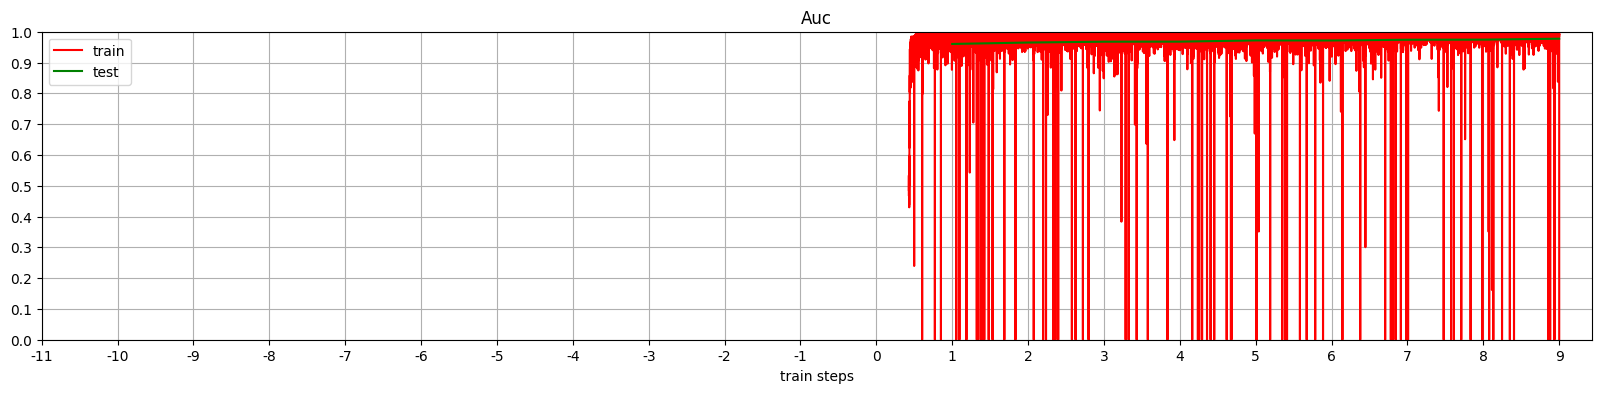

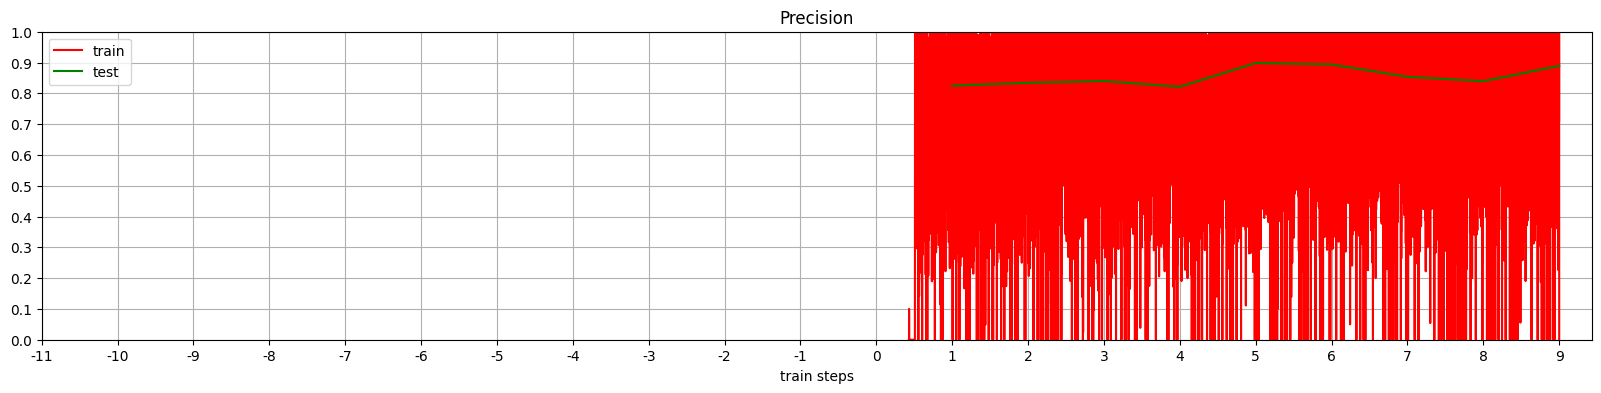

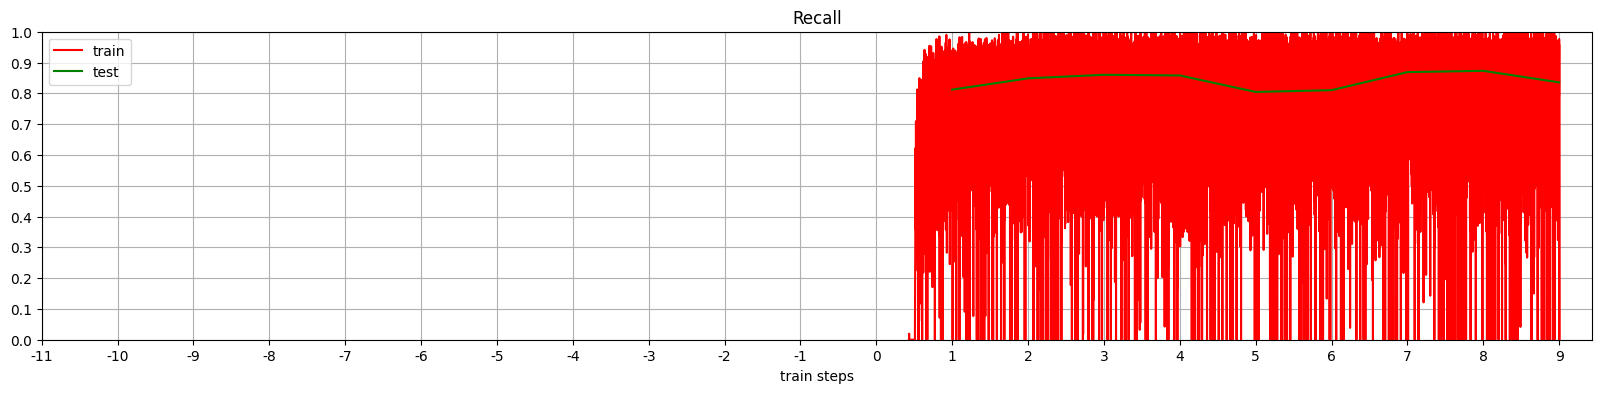

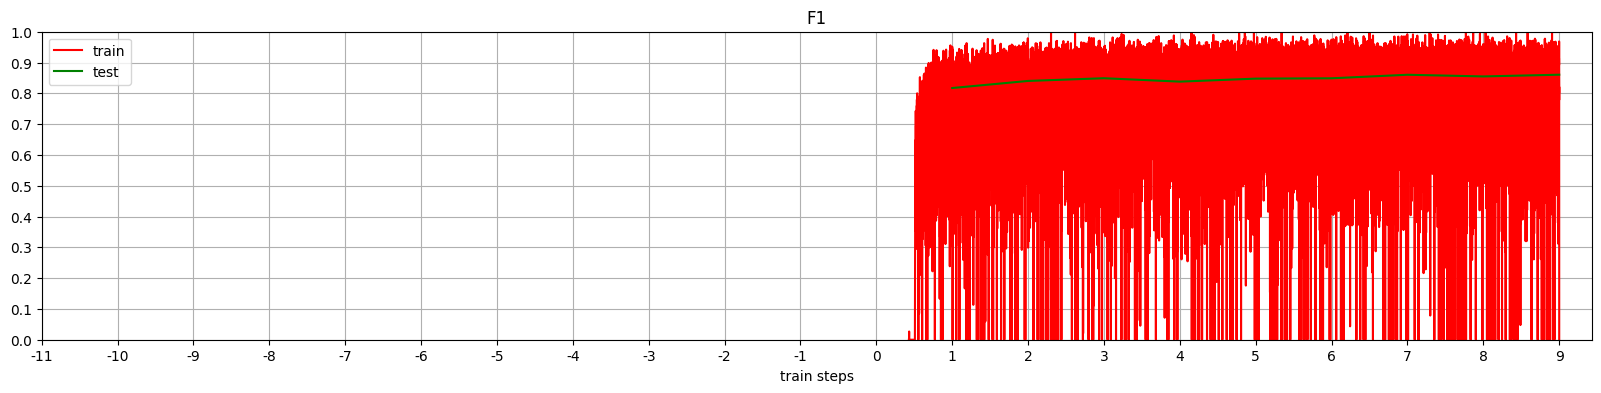

Time:  7.633199695746104
Max 4-mer. Epoch 9: ROC-AUC = 0.977
Max 4-mer. Epoch 9:  Precision = 0.889
Max 4-mer. Epoch 9: Recall = 0.836
Max 4-mer. Epoch 9: F1-score = 0.86
Max 4-mer. Final ROC-AUC = 0.977
Max 4-mer. Final Precision = 0.889
Max 4-mer. Final Recall = 0.836
Max 4-mer. Final F1-score = 0.86


In [ ]:
metrics = {}

max_length = 4
groups = generate_subgroups(max_length)
features_count = len(groups)

np.random.seed(42)
train_dataset = GraphDataset(chrom_names, feature_names,
                             DNA, DNA_features,
                             ZDNA, train_intervals,
                             max_length, groups)

test_dataset = GraphDataset(chrom_names, feature_names,
                            DNA, DNA_features,
                            ZDNA, test_intervals,
                            max_length, groups)
params = {'batch_size':32,
      'num_workers':4,
      'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv_13L(features_count)
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 9, loader_train, loader_test, max_length)

    

    
model_metric = {'Epoch':np.argmax(val_f1_log),
                'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                'Precision':val_pr_log[np.argmax(val_f1_log)],
                'Recall':val_rec_log[np.argmax(val_f1_log)],
                'Mean time':np.mean(times) / 60
               }
metrics[max_length] = model_metric

In [119]:
for max_length in range(4, 5):
    print(f'Max {max_length}-mer')
    print(f'Epoch: {metrics[max_length]["Epoch"]}')
    print(f'Max F1-score: {metrics[max_length]["Max F1-score"]:.3}')
    print(f'ROC-AUC: {metrics[max_length]["ROC-AUC"]:.3}')
    print(f'Precision: {metrics[max_length]["Precision"]:.3}')
    print(f'Recall: {metrics[max_length]["Recall"]:.3}')
    print(f'Mean time: {metrics[max_length]["Mean time"]:.3}')

Max 4-mer
Epoch: 8
Max F1-score: 0.86
ROC-AUC: 0.977
Precision: 0.889
Recall: 0.836
Mean time: 7.68


In [19]:
import pickle
with open('model1234_862.pkl','wb') as file:
    pickle.dump(model, file)

In [120]:
torch.save(model, 'model1234_86_2.pt')

# Прогоны 1+2+3, 1+2+3+4

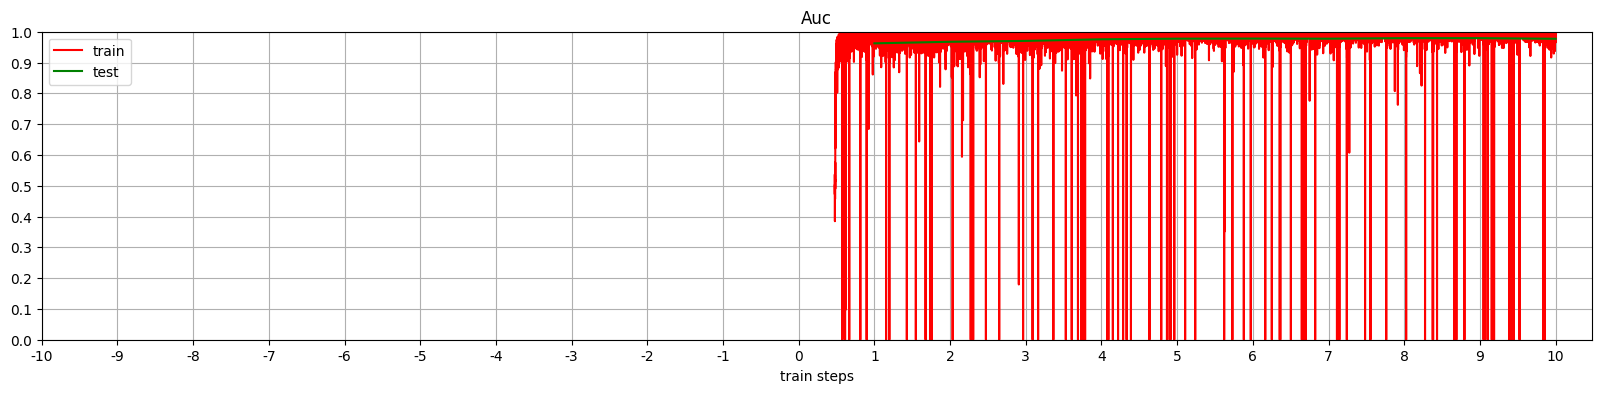

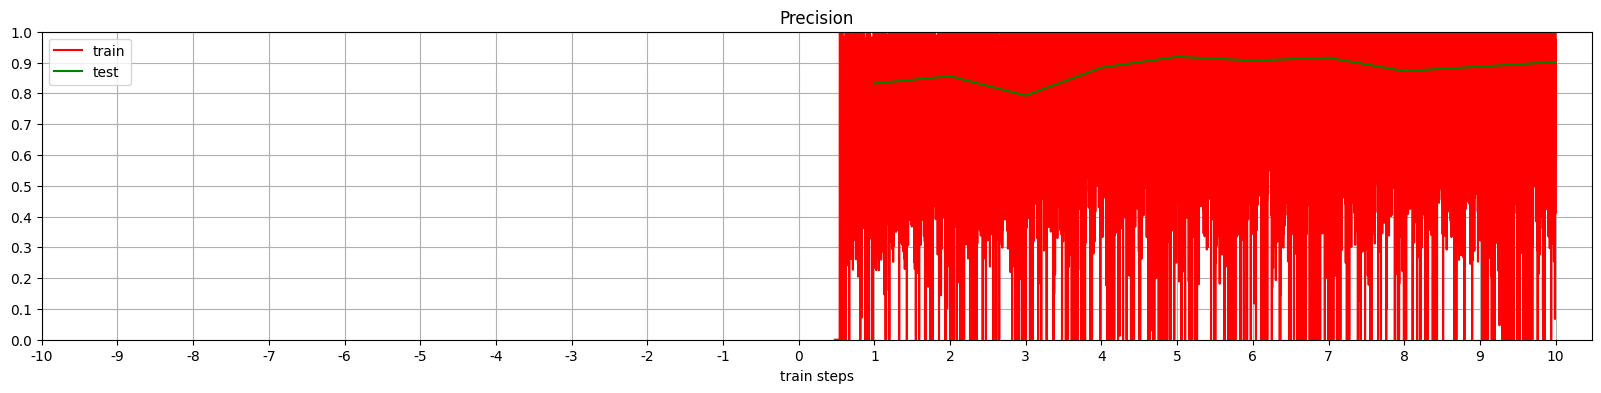

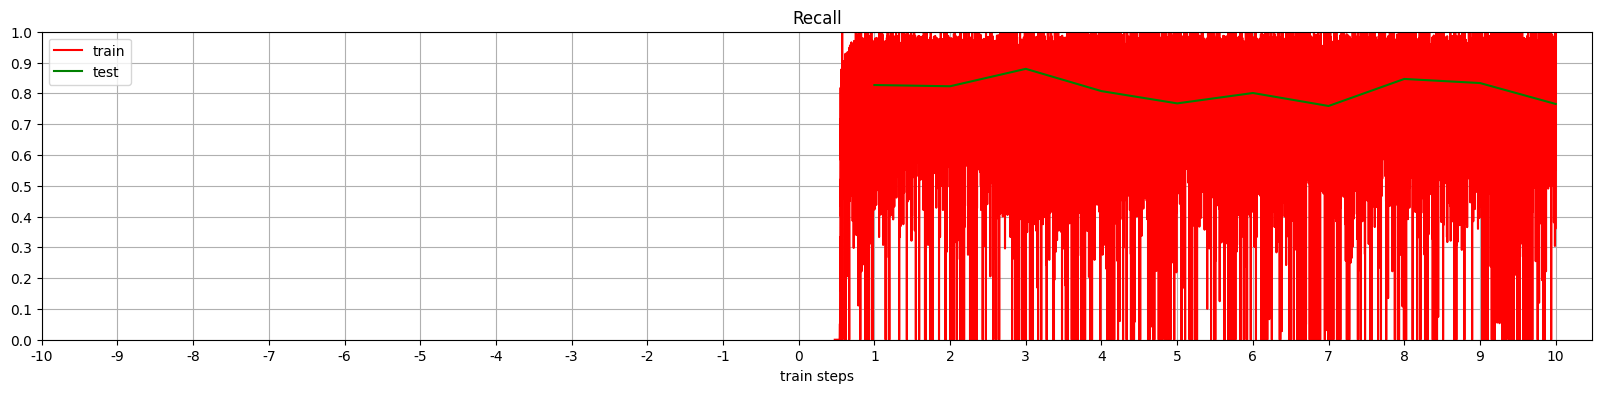

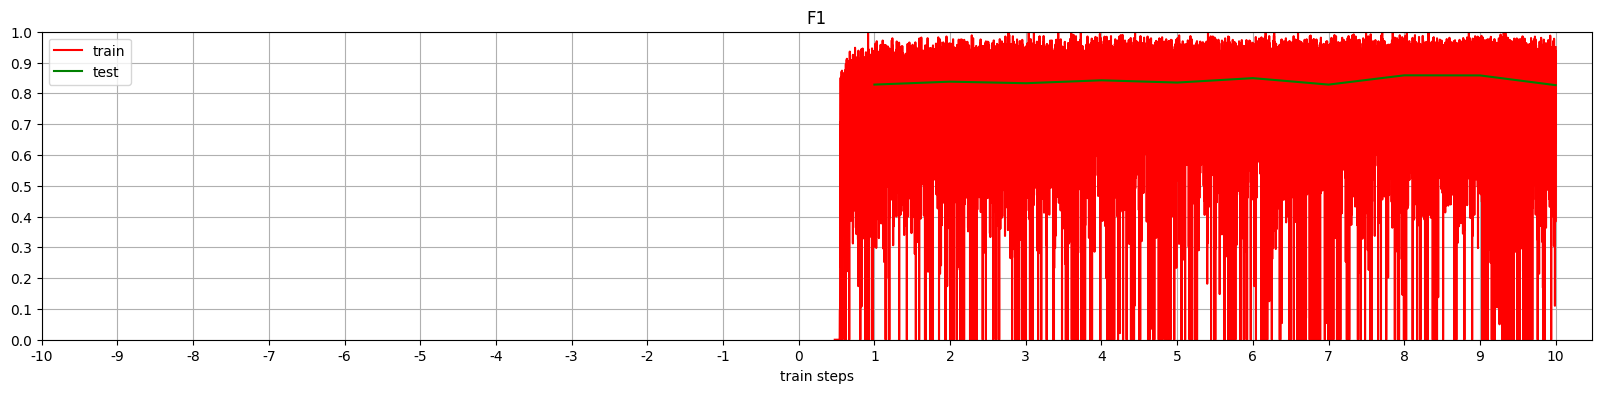

Time:  47.82477074066798
Max 5-mer. Epoch 10: ROC-AUC = 0.977
Max 5-mer. Epoch 10:  Precision = 0.902
Max 5-mer. Epoch 10: Recall = 0.765
Max 5-mer. Epoch 10: F1-score = 0.826
Max 5-mer. Final ROC-AUC = 0.977
Max 5-mer. Final Precision = 0.902
Max 5-mer. Final Recall = 0.765
Max 5-mer. Final F1-score = 0.826


In [ ]:
metrics = {}

for max_length in range(5, 6):
    groups = generate_subgroups(max_length)
    features_count = len(groups)
    
    np.random.seed(42)
    train_dataset = GraphDataset(chrom_names, feature_names,
                                 DNA, DNA_features,
                                 ZDNA, train_intervals,
                                 max_length, groups)

    test_dataset = GraphDataset(chrom_names, feature_names,
                                DNA, DNA_features,
                                ZDNA, test_intervals,
                                max_length, groups)
    params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

    loader_train = DataLoader(train_dataset, **params)
    loader_test = DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    set_random_seed(42)

    model = GraphZSAGEConv_13L(features_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test, max_length)
    
        
    worksheet.append_row(["GraphZSAGEConv_13L",
                          f'{features_count}',
                          f'{max_length}',
                          'Kouzine-Wu',
                          '100',
                          f'{val_f1_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.argmax(val_f1_log)}',
                          f'{val_auc_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.mean(times) / 60:.3}'
                         ]
                        )
        
    model_metric = {'Epoch':np.argmax(val_f1_log),
                    'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                    'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                    'Precision':val_pr_log[np.argmax(val_f1_log)],
                    'Recall':val_rec_log[np.argmax(val_f1_log)],
                    'Mean time':np.mean(times) / 60
                   }
    metrics[max_length] = model_metric


In [16]:
for max_length in range(3, 5):
    print(f'Max {max_length}-mer')
    print(f'Epoch: {metrics[max_length]["Epoch"]}')
    print(f'Max F1-score: {metrics[max_length]["Max F1-score"]:.3}')
    print(f'ROC-AUC: {metrics[max_length]["ROC-AUC"]:.3}')
    print(f'Precision: {metrics[max_length]["Precision"]:.3}')
    print(f'Recall: {metrics[max_length]["Recall"]:.3}')
    print(f'Mean time: {metrics[max_length]["Mean time"]:.3}')

Max 3-mer
Epoch: 9
Max F1-score: 0.857
ROC-AUC: 0.97
Precision: 0.843
Recall: 0.873
Mean time: 7.03
Max 4-mer
Epoch: 6
Max F1-score: 0.866
ROC-AUC: 0.978
Precision: 0.874
Recall: 0.86
Mean time: 12.3


In [ ]:
!pip install gspread pandas gspread-dataframe oauth2client

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]

creds = ServiceAccountCredentials.from_json_keyfile_name("service_account.json", scope)
client = gspread.authorize(creds)

spreadsheet = client.open_by_key("1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ")
worksheet = spreadsheet.worksheet('ATGC') 

In [ ]:
for max_length in range(3, 7):
    if max_length == 3:
        groups = '1+2+3'
    elif max_length == 4:
        groups = '1+2+3+4'
    elif max_length == 5:
        groups = '1+2+3+4+5'
    elif max_length == 6:
        groups = '1+2+3+4+5+6'
        
    worksheet.append_row(["GraphZSAGEConv_13L",
                          "?",
                          groups,
                          'Kouzine-Wu',
                          100,
                          metrics[max_length]["Max F1-score"],
                          metrics[max_length]["Epoch"],
                          metrics[max_length]["ROC-AUC"],
                          metrics[max_length]["Mean time"]
                         ]
                        )

# Запуски просто 3, 4, 5, 6

In [18]:
def generate_subgroups_just_n(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    subgroups.extend([''.join(p) for p in product(nucleotides, repeat=n)])
    return subgroups

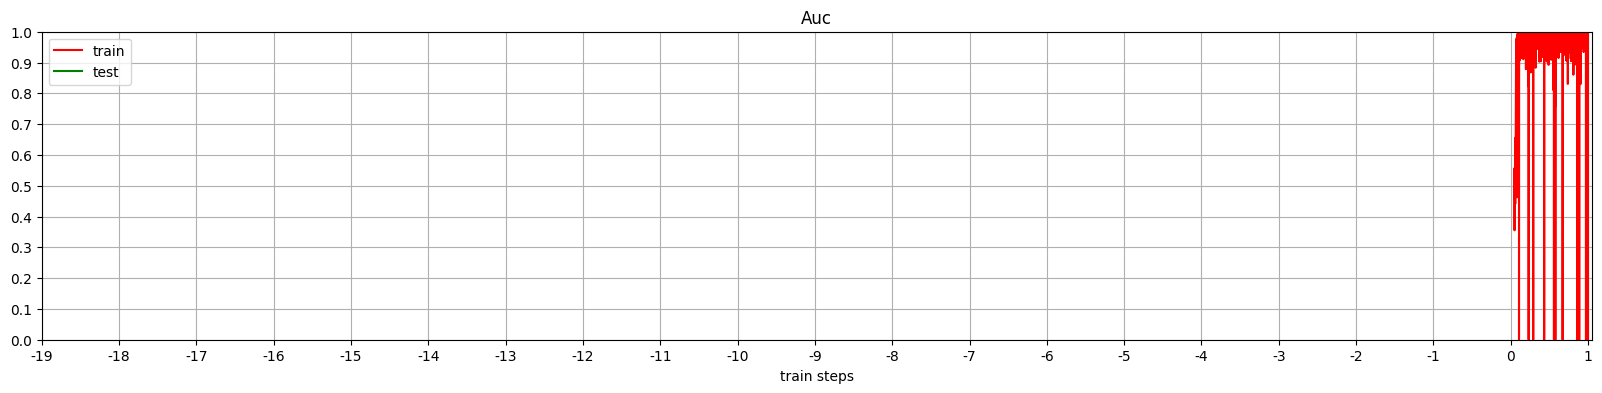

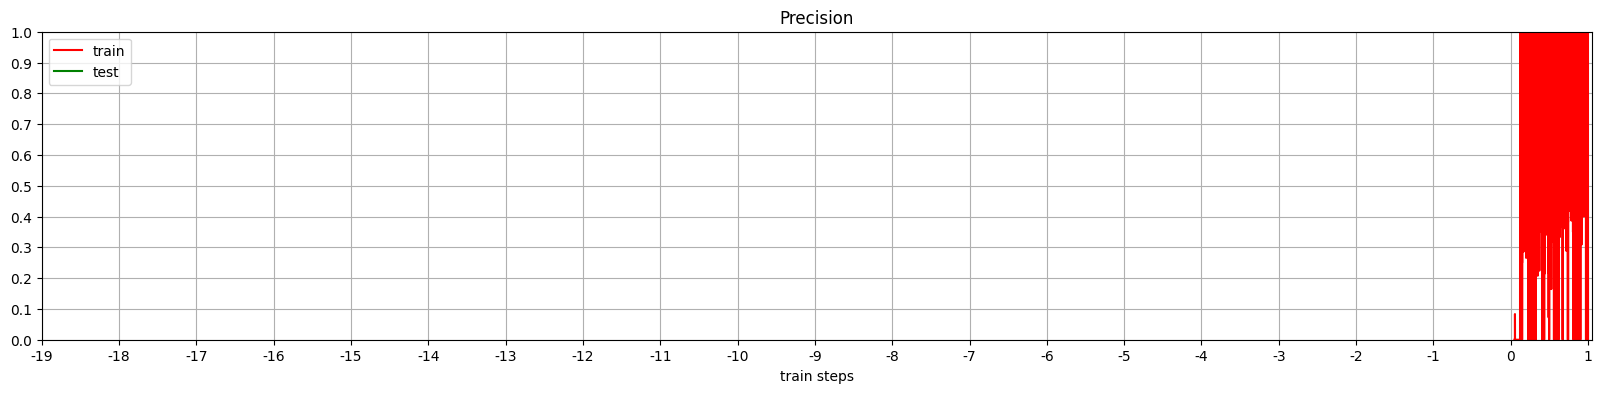

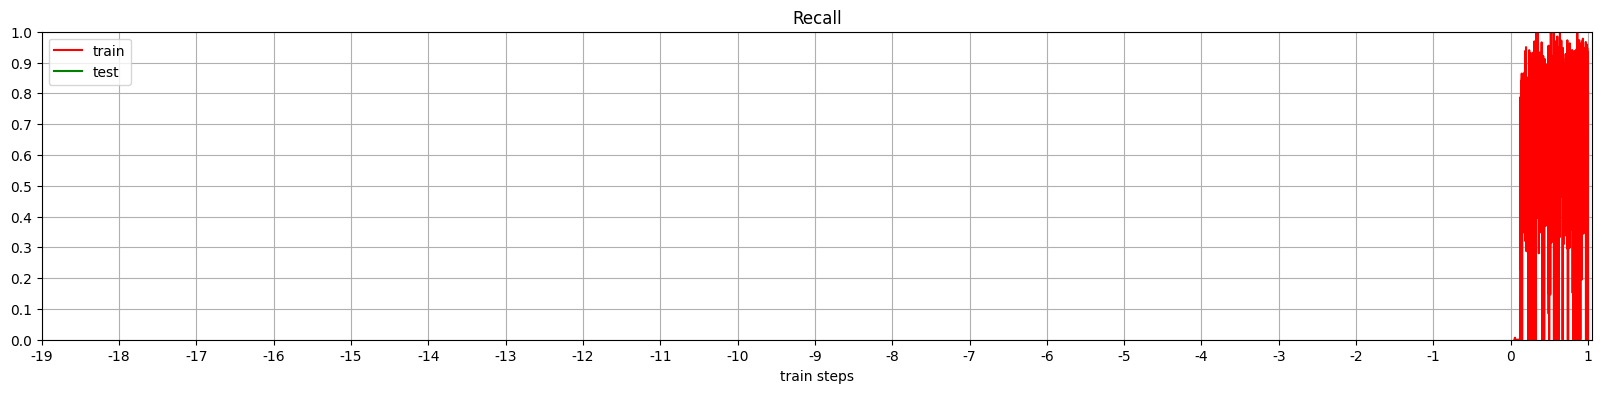

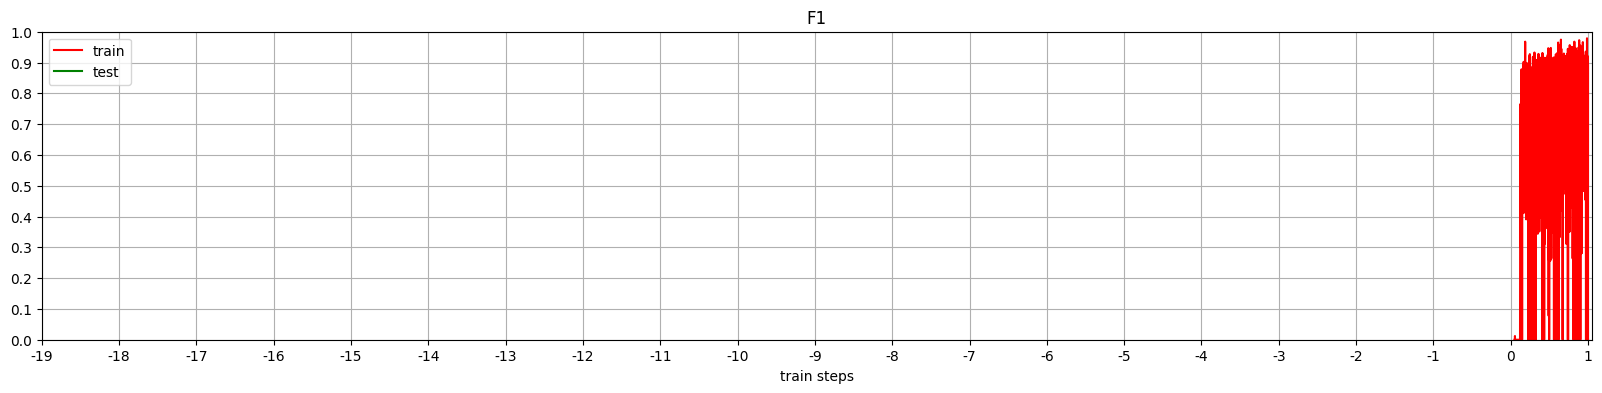

Time:  141.44741825262705
Max 6-mer. Epoch 1: ROC-AUC = 0.963
Max 6-mer. Epoch 1:  Precision = 0.953
Max 6-mer. Epoch 1: Recall = 0.526
Max 6-mer. Epoch 1: F1-score = 0.676
Max 6-mer. Epoch 2 of 10


/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

In [ ]:
metrics = {}

for max_length in range(5, 7):
    groups = generate_subgroups_just_n(max_length)
    features_count = len(groups)
    
    np.random.seed(42)
    train_dataset = GraphDataset(chrom_names, feature_names,
                                 DNA, DNA_features,
                                 ZDNA, train_intervals,
                                 max_length, groups)

    test_dataset = GraphDataset(chrom_names, feature_names,
                                DNA, DNA_features,
                                ZDNA, test_intervals,
                                max_length, groups)
    params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

    loader_train = DataLoader(train_dataset, **params)
    loader_test = DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    set_random_seed(42)

    model = GraphZSAGEConv_13L(features_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test, max_length)
        
    worksheet.append_row(["GraphZSAGEConv_13L",
                          f'{features_count}',
                          f'{max_length}',
                          'Kouzine-Wu',
                          '100',
                          f'{val_f1_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.argmax(val_f1_log)}',
                          f'{val_auc_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.mean(times) / 60:.3}'
                         ]
                        )
        
    model_metric = {'Epoch':np.argmax(val_f1_log),
                    'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                    'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                    'Precision':val_pr_log[np.argmax(val_f1_log)],
                    'Recall':val_rec_log[np.argmax(val_f1_log)],
                    'Mean time':np.mean(times) / 60
                   }
    metrics[max_length] = model_metric

In [ ]:
for max_length in range(3, 7):
    print(f'Max {max_length}-mer')
    print(f'Epoch: {metrics[max_length]["Epoch"]}')
    print(f'Max F1-score: {metrics[max_length]["Max F1-score"]:.3}')
    print(f'ROC-AUC: {metrics[max_length]["ROC-AUC"]:.3}')
    print(f'Precision: {metrics[max_length]["Precision"]:.3}')
    print(f'Recall: {metrics[max_length]["Recall"]:.3}')
    print(f'Mean time: {metrics[max_length]["Mean time"]:.3}')